# Comment Toxicity Detection for WikiShop

**Project Overview**
The goal is to build a machine learning model that can automatically detect toxic comments in user-generated text for the WikiShop platform — an online store that allows customers to collaboratively edit and comment on product descriptions, similar to a wiki community.

Toxic comments can negatively affect the user experience and community engagement, so this model serves as a moderation tool to flag such content before it appears publicly.

**Project Objectives**
- Load and preprocess the dataset containing labeled comments.
- Perform text cleaning, tokenization, and vectorization (TF-IDF, Word2Vec, or BERT).
- Train and evaluate multiple models (e.g., Logistic Regression, LightGBM, BERT-based model).
- Achieve an F1-score ≥ 0.75 on the validation dataset.
  
**Project Workflow**

1. Data Preparation
2. Text Preprocessing
3. Model Training
4. Evaluation
5. Conclusion



## Data Preparation

In [1]:
#Import the libraries and read the CSV files
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Загрузка ресурсов
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read the CSV files and load them into the corresponding DataFrames
tc = pd.read_csv('//datasets/toxic_comments.csv', sep=',',index_col=[0])
tc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [3]:
# Let's look at our table
tc.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# Check for duplicates and missing values
print(f"Duplicates found: {tc.duplicated().sum()}")
print(f"Missing values in 'text': {tc['text'].isna().sum()}")
print(f"Missing values in 'toxic': {tc['toxic'].isna().sum()}")

Duplicates found: 0
Missing values in 'text': 0
Missing values in 'toxic': 0


A dataset containing comment texts and their toxicity labels has been loaded, consisting of 159,292 rows. The data is in English. There are no missing values or duplicates, and the columns are ready for further analysis.

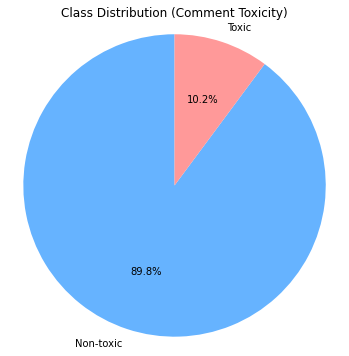

In [6]:
# Let's look at the class balance

# Counting the number of toxic and non-toxic comments
class_counts = tc['toxic'].value_counts()
labels = ['Non-toxic', 'Toxic']

# Building a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution (Comment Toxicity)')
plt.axis('equal')
plt.show()

We can see that nearly 90% of the comments are non-toxic, which is a good indicator. However, the class imbalance will need to be taken into account when building the models.

## Text Preprocessing

In [7]:
# Loading the English spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


In [8]:
# Performing batch lemmatization of the text using spaCy:
def lemmatize_batch(texts):
    docs = nlp.pipe(texts, batch_size=50, n_process=-1)
    lemmatized_texts = []
    for doc in docs:
        lemmas = [token.lemma_ for token in doc 
                  if not token.is_punct and not token.like_num and not token.is_stop]
        lemmatized_texts.append(" ".join(lemmas))
    return lemmatized_texts


In [9]:
# Cleaning: removing special characters and extra spaces
def clear_text(text):
    if not isinstance(text, str):
        return ""
    # Keep only Latin alphabet letters
    non_alpha = re.compile(r'[^a-zA-Z ]')
    multiple_spaces = re.compile(r'\s+')
    
    text = non_alpha.sub(' ', text)           # Removed all unnecessary elements
    text = multiple_spaces.sub(' ', text)     # Removed extra spaces
    return text.strip().lower()               # Converted to lowercase

In [10]:
# Main processing function
def process_dataframe(df):
    df = df.copy()
    df['cleaned'] = df['text'].apply(clear_text)
    df['text_clean_lemma'] = lemmatize_batch(df['cleaned'])
    return df

In [11]:
# Apply it to our data
tc = process_dataframe(tc)

In [12]:
# Let’s check the result
tc.head()

,text,toxic,cleaned,text_clean_lemma
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww match background colour m seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man m try edit war s guy constantly remove...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,t real suggestion improvement wonder section s...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [13]:
# Create a copy of the table
tc_sample = tc

## Model Training

In [14]:
# Split the data
X = tc_sample[['text_clean_lemma']]
y = tc_sample['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [15]:
# Preprocessor for the pipeline: apply TF-IDF vectorization to the 'text_clean_lemma' column
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', dtype=np.float32), 'text_clean_lemma')
    ]
)

In [16]:
# Define the models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(class_weight='balanced', max_iter=1000)
}

In [17]:
# Hyperparameters for tuning
param_grid = {
    'preprocessor__text__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__text__min_df': [1,3],
    'preprocessor__text__max_df': [0.9, 0.95]
}

In [18]:
# Function for training the model and returning grid.best_estimator_
def train_model_and_get_best(model_name, model, X_train, y_train, param_grid):
    print(f"🔧 Обучаем модель: {model_name}")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(stop_words='english', dtype=np.float32), 'text_clean_lemma')
        ]
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    print(f"✅ Лучшая F1 на кросс-валидации: {grid.best_score_:.3f}")
    print(f"Параметры: {grid.best_params_}")
    
    return grid.best_estimator_


In [19]:
# Train a logistic regression model with hyperparameter tuning using GridSearchCV
best_logreg = train_model_and_get_best(
    model_name='LogisticRegression',
    model= models['LogisticRegression'],
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid
)


🔧 Обучаем модель: LogisticRegression
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Лучшая F1 на кросс-валидации: 0.754
Параметры: {'preprocessor__text__max_df': 0.9, 'preprocessor__text__min_df': 3, 'preprocessor__text__ngram_range': (1, 2)}


In [21]:
# Train a MultinomialNB model with hyperparameter tuning using GridSearchCV
best_nb = train_model_and_get_best('MultinomialNB', models['MultinomialNB'], X_train, y_train, param_grid)

🔧 Обучаем модель: MultinomialNB
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Лучшая F1 на кросс-валидации: 0.565
Параметры: {'preprocessor__text__max_df': 0.9, 'preprocessor__text__min_df': 3, 'preprocessor__text__ngram_range': (1, 1)}


In [23]:
# Train a LinearSVC model with hyperparameter tuning using GridSearchCV
best_svc = train_model_and_get_best('LinearSVC', models['LinearSVC'], X_train, y_train, param_grid)

🔧 Обучаем модель: LinearSVC
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Лучшая F1 на кросс-валидации: 0.789
Параметры: {'preprocessor__text__max_df': 0.9, 'preprocessor__text__min_df': 1, 'preprocessor__text__ngram_range': (1, 2)}


The best result was achieved by the LinearSVC model with an F1 score of 0.789 on the training set. This exceeds the required threshold of 0.75. Let’s evaluate it on the test set.

In [24]:
y_pred = best_svc.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1 on the test set: {f1:.3f}")

F1 on the test set: 0.792


On the test set, it also showed an excellent result — 0.792

## Conclusion

In this project, a binary classification task for detecting toxic comments in English was successfully completed. After data cleaning, lemmatization, and text vectorization using TfidfVectorizer, several basic machine learning models were trained and compared:

Logistic Regression — showed stable performance with an F1 score of 0.754 on the training data.

Multinomial Naive Bayes — delivered significantly lower performance (F1 0.565 on the training data), making it the least suitable among the tested models.

Linear Support Vector Classifier (LinearSVC) — performed best, achieving F1 = 0.792 on the test set and 0.789 during cross-validation.

All models used a unified pipeline with hyperparameter tuning via GridSearchCV, including parameters such as ngram range, min_df, and max_df. A ColumnTransformer was also implemented to flexibly configure preprocessing for different features.

As a result, the LinearSVC model proved to be the most effective according to the F1 metric and successfully surpassed the threshold of 0.75, meaning the task was completed successfully.
Model performance could be further improved with more advanced features, word embeddings, BERT-based models, or the inclusion of metadata (e.g., text length or keyword frequency). However, within the current resource constraints, the achieved result is optimal.